In [6]:
# !pip install --quiet matplotlib
# !pip install --quiet seaborn
# !pip install --quiet tqdm
# ! pip install --quiet ipywidgets
# !!pip install --quiet einops

In [2]:
## Standard libraries
import os
import numpy as np
import math
import json
from functools import partial



## Imports for plotting

import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')  # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

from einops import rearrange
from typing import Optional, Tuple, Dict

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100





<Figure size 640x480 with 0 Axes>

In [2]:

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial6_jax"


In [8]:

print("Device:", jax.devices()[0])

Device: TFRT_CPU_0


#### Multihead Attention

In [3]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.shape[-1]
    attn_logits = jnp.matmul(q, jnp.swapaxes(k, -2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = jnp.where(mask == 0, -9e15, attn_logits)
    attention = nn.softmax(attn_logits, axis=-1)
    values = jnp.matmul(attention, v)
    return values, attention

In [4]:
seq_len, d_k = 3, 2
main_rng, rand1 = random.split(main_rng)
qkv = random.normal(rand1, (3, L, d_k))
q, k, v = qkv[0], qkv[1], qkv[2]
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

NameError: name 'L' is not defined

#### Step 1: Understand Multi-head Latent Attention (MLA)

MLA modifies the standard Multi-head Attention (MHA) by:

 1. **Compressing Keys and Values:** Instead of storing full KV matrices, MLA projects them into a low-dimensional latent space (e.g., from $d_{model}$ to $latent_dim$, where $latent_dim << d_{model}$) using a down-projection matrix.
 2. **Reconstructing Keys and Values:** During attention computation, latent vectors are up-projected back to the original dimension using separate matrices for keys and values.
 3. **Decoupled RoPE:** Positional information (via RoPE) is handled separately to maintain compatibility with KV compression.
 4. **Query Handling:** Queries can also be compressed into a latent space and then up-projected, though this is optional depending on the design.

 The goal is to reduce the KV cache size (e.g., from $O(num_heads * d_h)$ to $O(latent_dim)$ per token, where $num_heads$ is the **number of heads** and $d_h$ is **the head dimension**) while preserving attention quality.

 $X\in \mathbb{R}^{T x D }$, where $T$ represents the sequence length and $D$ is the hidden dimension. 

#### Step 2: Define the Architecture

- Down-projection: A linear layer to compress KV into a latent vector.
- Up-projection: Two linear layers to reconstruct keys and values from the latent vector.
- Query projection: Optionally compress queries into a latent space, though typically queries remain in full dimension for flexibility.
- RoPE: A custom implementation for positional embeddings, decoupled from KV compression.
- Attention computation: Standard scaled dot-product attention using the reconstructed keys and values.



In [5]:
def rotary_embedding(x, max_seq_len, dim):
    """Apply RoPE to input tensor x."""
    # Ensure max_seq_len is a concrete value, not symbolic
    positions = jnp.arange(max_seq_len, dtype=jnp.float32)
    
    # Ensure freqs is calculated with concrete values for dim
    freqs = 1.0 / (10000 ** (jnp.arange(0, dim, 2, dtype=jnp.float32) / dim))
    
    # Angle calculation with fixed values
    angles = positions[:, None] * freqs[None, :]
    
    sin, cos = jnp.sin(angles), jnp.cos(angles)
    
    # Apply rotary embeddings to the input tensor x
    x1, x2 = x[..., ::2], x[..., 1::2]
    x_rotated = jnp.concatenate([x1 * cos - x2 * sin, x1 * sin + x2 * cos], axis=-1)
    
    return x_rotated

In [6]:
# Scaled Dot-Product Attention

@jax.jit
def scaled_dot_product(q, k, v, mask=None):
    """Computes the scaled dot-product attention."""
    # q -> [B, n_h, L, d_h + d_h^R] 
    # k -> [B, n_h, L, d_h + d_h^R] 
    scale = jnp.sqrt(q.shape[-1])  # Scaling factor for attention scores  d_h + d_h_r
    scores = jnp.einsum("bhqd,bhkd->bhqk", q, k) / scale  # Efficient batch matmul
    
    if mask is not None:
        scores += mask  # Apply mask in-place

    attention = nn.softmax(scores, axis=-1)  # Compute attention weights
    values = jnp.einsum("bhqk,bhkd->bhqd", attention, v)  # Apply attention to values

    return values, attention


In [7]:
# Helper function to support different mask shapes.
# Output shape supports (B, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
@jax.jit
def expand_mask(mask):
    """Expands a mask tensor to shape (B, num_heads, L, L)."""
    ndim = mask.ndim
    assert ndim >= 2, "Mask must be at least 2D (L x L)"

    # Efficient broadcasting using jnp.reshape and jnp.expand_dims
    if ndim == 2:  # (L, L) → (1, 1, L, L)
        return mask[None, None, :, :]
    elif ndim == 3:  # (B, L, L) → (B, 1, L, L)
        return mask[:, None, :, :]
    
    return mask  # If already (B, num_heads, L, L), return as is

### Original MHA with ROPE 

In [5]:
# class MultiHeadLatentAttentionRope(nn.Module):
#     d_model: int  # Output dimension
#     n_h: int  # Number of heads
#     d_c: int  # Latent compression dimension for KV
#     d_c_: int  # Latent compression dimension for Queries
#     d_h_R: int  # Rotated dimension for RoPE

#     def setup(self):
#         # self.d_h = self.d_model // self.n_h  # Head dimension

#         self.h_t = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)

#         # Combined projection for KV down-projection
#         self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
#         # Combined projection for up-projecting KV
#         self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

#         # Combined down-projection for Queries
#         self.q_proj = nn.Dense(self.d_c_ + self.d_h_R, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
#         # Up-projection for Queries
#         self.uq_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

#         # Rotated projection for keys (shared)
#         self.kr_proj = nn.Dense(self.d_h_R, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

#         # Output projection
#         self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

#     def __call__(self, x, mask=None):
#         B, L, _ = x.shape  # Batch size, Sequence length, Embedding dim

#         if mask is not None:
#             mask = expand_mask(mask)
        
#         x = self.h_t(x)

#         # Down-project and up-project KV (fused ops)
#         c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
#         k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each

#         # Down-project queries (fused with rotated part)
#         c_q = self.q_proj(x)  # [B, L, d_c_ + d_h_R]
#         q_c, q_r = jnp.split(c_q, [self.d_c_], axis=-1)  # [B, L, d_c_], [B, L, d_h_R]

#         # Up-project compressed queries
#         q_c = self.uq_proj(q_c)  # [B, L, d_model]

#         # Apply RoPE (optimized via vmap)
#         q_r = rotary_embedding(q_r, L, self.d_h_R)  # [B, L, d_h_R]
#         k_r = rotary_embedding(self.kr_proj(x), L, self.d_h_R)  # [B, L, d_h_R]

#         # Reshape heads using einops (faster)
#         q_c, k, v = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q_c, k, v])
#         q_r, k_r = map(lambda t: rearrange(t, "b l d -> b 1 l d").repeat(self.n_h, axis=1), [q_r, k_r])

#         # Concatenate query and key rotated parts
#         q = jnp.concatenate([q_c, q_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]
#         k = jnp.concatenate([k, k_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]

#         # Compute attention (efficient)
#         values, attention = scaled_dot_product(q, k, v, mask)

#         # Reshape and project output
#         values = rearrange(values, "b h l d -> b l (h d)")
#         return self.o_proj(values), attention


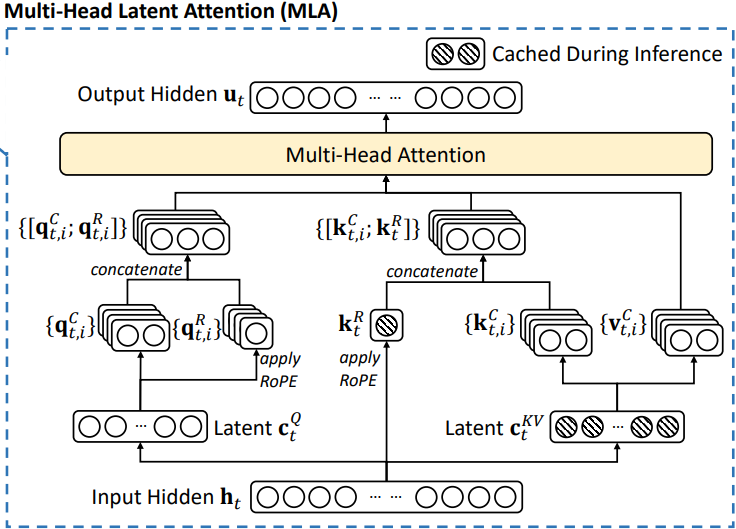

In [13]:
class MultiHeadLatentAttentionRope(nn.Module):
    d_model: int  # Output dimension
    n_h: int  # Number of heads
    d_c: int  # Latent compression dimension for KV
    d_c_: int  # Latent compression dimension for Queries
    d_h_R: int  # Rotated dimension for RoPE

    def setup(self):
        # self.d_h = self.d_model // self.n_h  # Head dimension
        self.input_h = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        # Combined projection for KV down-projection
        self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
        # Combined projection for up-projecting KV
        self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Combined down-projection for Queries
        self.q_proj = nn.Dense(self.d_c_ + self.d_h_R * self.n_h, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
        # Up-projection for Queries
        self.uq_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Rotated projection for keys (shared)
        self.kr_proj = nn.Dense(self.d_h_R , kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Output projection
        self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

    def __call__(self, x, mask=None):
        B, L, D = x.shape  # Batch size, Sequence length, Embedding dim

        if D != self.d_model:
            x = self.input_h(x)

        if mask is not None:
            mask = expand_mask(mask)

        # Down-project and up-project KV (fused ops)
        c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
        k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each


        # Down-project queries (fused with rotated part)
        c_q = self.q_proj(x)  # [B, L, d_c_ + d_h_R]
        q_c, q_r = jnp.split(c_q, [self.d_c_], axis=-1)  # [B, L, d_c_], [B, L, d_h_R]


        # Up-project compressed queries
        q_c = self.uq_proj(q_c)  # [B, L, d_model]

        # Apply RoPE (optimized via vmap)
        q_r = rotary_embedding(q_r, L, self.d_h_R * self.n_h)  # [batch_size, seq_len, d_h_R]
        k_r = rotary_embedding(self.kr_proj(x), L, self.d_h_R)  # [batch_size, seq_len, d_h_R]

        k_r = jnp.expand_dims(k_r, axis=2) # Shape: [batch_size, seq_len, 1, d_h_R]
        # Broadcast to the desired shape [batch_size, seq_len, num_heads, d_h_R]
        print(k_r.shape)

        k_r = rearrange(jnp.broadcast_to(k_r, (k_r.shape[0], k_r.shape[1], self.n_h, k_r.shape[3])), "b l h d -> b h l d", h=self.n_h, l = L)
        print(k_r.shape)

        # Reshape heads using einops (faster)
        q_c, k, v, q_r = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q_c, k, v, q_r])

    
        # Concatenate query and key rotated parts
        q = jnp.concatenate([q_c, q_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]
        k = jnp.concatenate([k, k_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]

        # Compute attention (efficient)
        values, attention = scaled_dot_product(q, k, v, mask)

        # Reshape and project output
        values = rearrange(values, "b h l d -> b l (h d)")
        return self.o_proj(values), attention


In [14]:
# Test with random inputs
x = jax.random.normal(jax.random.PRNGKey(0), (2, 15, 10))  # [Batch, Sequence, d_model]

# Initialize model parameters
model = MultiHeadLatentAttentionRope(d_model=64, n_h=8, d_c=32, d_c_=16, d_h_R=32)
params = model.init(jax.random.PRNGKey(0), x)

# Perform a forward pass
output, attention = model.apply(params, x)

# Output results
print("Output:", output.shape)  # Expected: [2, 10, 64]
print("Attention:", attention.shape)  # Expected: [2, 8, 10, 10]


(2, 15, 1, 32)
(2, 8, 15, 32)
(2, 15, 1, 32)
(2, 8, 15, 32)
Output: (2, 15, 64)
Attention: (2, 8, 15, 15)


In [ ]:
# class MultiHeadLatentAttention(nn.Module):
#     d_model: int  # Output dimension
#     n_h: int  # Number of heads
#     d_c: int  # Latent compression dimension for KV
#     d_c_: int  # Latent compression dimension for Queries
#     d_h_R: int  # Rotated dimension for RoPE

#     def setup(self):
#         # self.d_h = self.d_model // self.n_h  # Head dimension

#         # Combined projection for KV down-projection
#         self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
#         # Combined projection for up-projecting KV
#         self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

#         # Combined down-projection for Queries
#         self.q_proj = nn.Dense(self.d_c_ + self.d_h_R, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
#         # Up-projection for Queries
#         self.uq_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

#         # Rotated projection for keys (shared)
#         self.kr_proj = nn.Dense(self.d_h_R, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

#         # Output projection
#         self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

#     def __call__(self, x, mask=None):
#         B, L, _ = x.shape  # Batch size, Sequence length, Embedding dim

#         if mask is not None:
#             mask = expand_mask(mask)

#         # Down-project and up-project KV (fused ops)
#         c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
#         k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each

#         # Down-project queries (fused with rotated part)
#         c_q = self.q_proj(x)  # [B, L, d_c_ + d_h_R]
#         q_c, q_r = jnp.split(c_q, [self.d_c_], axis=-1)  # [B, L, d_c_], [B, L, d_h_R]

#         # Up-project compressed queries
#         q_c = self.uq_proj(q_c)  # [B, L, d_model]

#         # Apply RoPE (optimized via vmap)
#         q_r = rotary_embedding(q_r, L, self.d_h_R)  # [B, L, d_h_R]
#         k_r = rotary_embedding(self.kr_proj(x), L, self.d_h_R)  # [B, L, d_h_R]

#         # Reshape heads using einops (faster)
#         q_c, k, v = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q_c, k, v])
#         q_r, k_r = map(lambda t: rearrange(t, "b l d -> b 1 l d").repeat(self.n_h, axis=1), [q_r, k_r])

#         # Concatenate query and key rotated parts
#         q = jnp.concatenate([q_c, q_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]
#         k = jnp.concatenate([k, k_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]

#         # Compute attention (efficient)
#         values, attention = scaled_dot_product(q, k, v, mask)

#         # Reshape and project output
#         values = rearrange(values, "b h l d -> b l (h d)")
#         return self.o_proj(values), attention


In [8]:
# Example usage
def main():
    # Hyperparameters
    dim = 512  # Output dimension
    num_heads = 8
    latent_dim = 128  # Latent dimension (d_c)
    rotary_dim = 32  # Rotated dimension (d_h^R)
    seq_len = 64
    batch_size = 2
    
    # d_model: int  # Output dimension (d_model)
    # n_h: int  # Number of parallel heads (h)
    # d_c : int # Latent dimension for compression (d_c) kv
    # d_c_ : int # Latent dimension for compression (d_c') queries
    # d_h_R: int  # Rotated dimension for RoPE (d_h^R)
    # Initialize model
    rng = jax.random.PRNGKey(0)
    model = MultiHeadLatentAttention(
        d_model=dim, n_h=num_heads, d_c=latent_dim,d_c_ = latent_dim, d_h_R=rotary_dim
    )
    x = jax.random.normal(rng, (batch_size, seq_len, dim))
    params = model.init(rng, x)

    # Forward pass
    output, attention = model.apply(params, x)
    print("Output shape:", output.shape)  # Should be [batch_size, seq_len, dim]
    print("Attention shape:", attention.shape)  # Should be [batch_size, num_heads, seq_len, seq_len]


In [9]:
%%timeit
main()

Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
56.8 ms ± 3.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### MLA



In [10]:
class MultiHeadLatentAttention(nn.Module):
    d_model: int  # Output dimension
    n_h: int  # Number of heads
    d_c: int  # Latent compression dimension

    def setup(self):
        self.d_h = self.d_model // self.n_h  # Head dimension

        # Fused projection layers
        self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
        self.q_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
        self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Up-projection for keys & values
        self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

    def __call__(self, x, mask=None):
        B, L, _ = x.shape  # Batch size, Sequence length, Embedding dim

        if mask is not None:
            mask = expand_mask(mask)

        # Compute compressed KV projection
        c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
        k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each

        # Compute query projection
        q = self.q_proj(x)  # [B, L, d_model]

        # Reshape using einops for efficiency
        q, k, v = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q, k, v])

        # Compute attention (optimized version)
        values, attention = scaled_dot_product(q, k, v, mask)

        # Reshape and output projection
        values = rearrange(values, "b h l d -> b l (h d)")
        return self.o_proj(values), attention

### WQ down
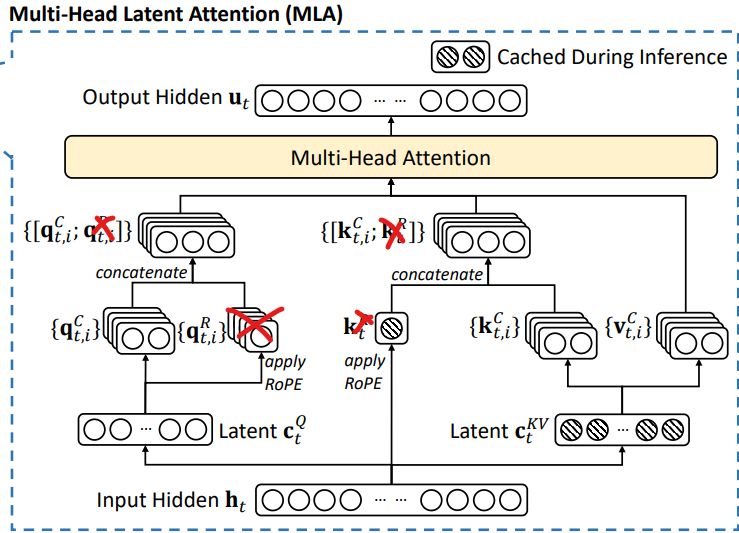

In [18]:
class MultiHeadLatentAttention(nn.Module):
    d_model: int  # Output dimension
    n_h: int  # Number of heads
    d_c: int  # Latent compression dimension
    d_c_: int #Latent caompression dimension fro Q

    def setup(self):
        #self.d_h = self.d_model // self.n_h  # Head dimension

       # Fused projection layers for efficiency
        self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.q_proj = nn.Dense(self.d_c_, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)

        # Up-projection for keys, values, and queries
        self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.uq_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)

        # Output projection
        self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros) 

    def __call__(self, x, mask=None):
        B, L, _ = x.shape  # Batch size, Sequence length, Embedding dim

        if mask is not None:
            mask = expand_mask(mask)

        # Compute compressed KV projection
        c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
        k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each

        # Compute query projection
        q = self.uq_proj(self.q_proj(x))  # [B, L, d_model]

        # Reshape using einops for efficiency
        q, k, v = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q, k, v])

        # Compute attention (optimized version)
        values, attention = scaled_dot_product(q, k, v, mask)

        # Reshape and output projection
        values = rearrange(values, "b h l d -> b l (h d)")
        return self.o_proj(values), attention

In [19]:
# Example usage
def main():
    # Hyperparameters
    dim = 512  # Output dimension
    num_heads = 8
    latent_dim = 128  # Latent dimension (d_c)
    latent_dim_q = 64
    seq_len = 64
    batch_size = 2
    
    # d_model: int  # Output dimension (d_model)
    # n_h: int  # Number of parallel heads (h)
    # d_c : int # Latent dimension for compression (d_c) kv
   
    # Initialize model
    rng = jax.random.PRNGKey(0)
    model = MultiHeadLatentAttention(d_model=dim, n_h=num_heads, d_c=latent_dim, d_c_= latent_dim_q )
    x = jax.random.normal(rng, (batch_size, seq_len, dim))
    params = model.init(rng, x)

    # Forward pass
    output, attention = model.apply(params, x)
    print("Output shape:", output.shape)  # Should be [batch_size, seq_len, dim]
    print("Attention shape:", attention.shape)  # Should be [batch_size, num_heads, seq_len, seq_len]


In [20]:
%%timeit
main()

Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 6

In [12]:
# Multi-head Latent Attention Module
class MultiHeadLatentAttention(nn.Module):
    d_model: int  # Output dimension (d_model)
    n_h: int  # Number of parallel heads (h)
    d_c : int # Latent dimension for compression (d_c) kv

    def setup(self):
        self.d_h = self.d_model // self.n_h

        # Down-projection for KV
        self.dkv_proj = nn.Dense(
            features=self.d_c, 
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=nn.initializers.zeros
        )  # W^DKV
        
        # Up-projection for keys (compressed part)
        self.uk_proj = nn.Dense(
            features=self.d_model,   # d_h * n_h = d_model
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=nn.initializers.zeros
        )  # W^UK

        # Up-projection for values
        self.uv_proj = nn.Dense(
            features=self.d_model, # d_h * n_h = d_model
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=nn.initializers.zeros
        )  # W^UV

        # projection for queries (compressed part)
        self.q_proj = nn.Dense(
            features=self.d_model,  # W^{UQ} (d_h n_h x d_c' (d_c_))  c^Q (d_c')
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=nn.initializers.zeros
        )  # W^Q

        # Output projection
        self.o_proj = nn.Dense(
            features=self.d_model,
            kernel_init=nn.initializers.xavier_uniform(),
            bias_init=nn.initializers.zeros
        )

    def __call__(self, x, mask=None):
        B, L, _ = x.shape  # Batch, Sequence Length, Dimension
    

        if mask is not None:
            mask = expand_mask(mask)

      
        # Down-project KV
        c_kv = self.dkv_proj(x)  # c_t^KV = W^DKV h_t [B, L, d_c]
        # Up-project keys (compressed part)
        k = self.uk_proj(c_kv)  # k_t^C = W^UK c_t^KV [B, L, dim]
        k = k.reshape(B, L, self.n_h, self.d_h)
        k = k.transpose(0, 2, 1, 3)
        # Up-project values
        v = self.uv_proj(c_kv)  # v_t^C = W^UV c_t^KV [B, L, dim]
        v = v.reshape(B, L, self.n_h, self.d_h)
        v = v.transpose(0, 2, 1, 3)
  
        # project queries
        q = self.q_proj(x)  # c_t^Q = W^Q h_t [B, L, dim]
        q = q.reshape(B, L, self.n_h, self.d_h)
        q = q.transpose(0, 2, 1, 3)
      
          
        # Attention computation
        values, attention = scaled_dot_product(q, k, v, mask=mask) #[B, n_h, L , d_h]

        values = values.transpose(0, 2, 1, 3)  #  [B, L, n_h, d_h]
        values = values.reshape(B, L, self.n_h * self.d_model // self.n_h) #[B, L, n_h * d_h]


       
        o = self.o_proj(values)  # [B, L, d_model]

        return o, attention

In [13]:
%%timeit
main()

Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
39.2 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Multihead Latent Attention Position  with Norm

In [13]:
class MultiHeadLatentAttentionRope(nn.Module):
    d_model: int  # Output dimension
    n_h: int  # Number of heads
    d_c: int  # Latent compression dimension for KV
    d_c_: int  # Latent compression dimension for Queries
    d_h_R: int  # Rotated dimension for RoPE

    def setup(self):
        # self.d_h = self.d_model // self.n_h  # Head dimension
        self.input_h = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        # Combined projection for KV down-projection
        self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
        # Combined projection for up-projecting KV
        self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Combined down-projection for Queries
        self.q_proj = nn.Dense(self.d_c_ + self.d_h_R * self.n_h, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  
        # Up-projection for Queries
        self.uq_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Rotated projection for keys (shared)
        self.kr_proj = nn.Dense(self.d_h_R , kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        # Output projection
        self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)  

        self.rmsNormV_c = nn.RMSNorm()
        self.rmsNormK_c = nn.RMSNorm()
        self.rmsNormQ_c = nn.RMSNorm()


    def __call__(self, x, mask=None):
        B, L, D = x.shape  # Batch size, Sequence length, Embedding dim

        if D != self.d_model:
            x = self.input_h(x)

        if mask is not None:
            mask = expand_mask(mask)

        # Down-project and up-project KV (fused ops)
        c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
        k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each


        # Down-project queries (fused with rotated part)
        c_q = self.q_proj(x)  # [B, L, d_c_ + d_h_R]
        q_c, q_r = jnp.split(c_q, [self.d_c_], axis=-1)  # [B, L, d_c_], [B, L, d_h_R]


        # Up-project compressed queries
        q_c = self.uq_proj(q_c)  # [B, L, d_model]

        # Apply RoPE (optimized via vmap)
        q_r = rotary_embedding(q_r, L, self.d_h_R * self.n_h)  # [batch_size, seq_len, d_h_R]
        k_r = rotary_embedding(self.kr_proj(x), L, self.d_h_R)  # [batch_size, seq_len, d_h_R]

        k_r = jnp.expand_dims(k_r, axis=2) # Shape: [batch_size, seq_len, 1, d_h_R]
        # Broadcast to the desired shape [batch_size, seq_len, num_heads, d_h_R]
       

        # k_r = rearrange(jnp.broadcast_to(k_r, (k_r.shape[0], k_r.shape[1], self.n_h, k_r.shape[3])), "b l h d -> b h l d", h=self.n_h, l = L)
        k_r = rearrange(k_r, "b l d -> b 1 l d").repeat(self.n_h, axis=1)  # Expand heads


        v = self.rmsNormV_c(v)
        k = self.rmsNormK_c(k)
        q_c = self.rmsNormQ_c(q_c)

        
        # Reshape heads using einops (faster)
        q_c, k, v, q_r = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q_c, k, v, q_r])

        # Concatenate query and key rotated parts
        q = jnp.concatenate([q_c, q_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]
        k = jnp.concatenate([k, k_r], axis=-1)  # [B, n_h, L, d_h + d_h^R]

        # Compute attention (efficient)
        values, attention = scaled_dot_product(q, k, v, mask)

        # Reshape and project output
        values = rearrange(values, "b h l d -> b l (h d)")
        return self.o_proj(values), attention


### Multihead Latent Attention  with Norm

In [14]:
class MultiHeadLatentAttention(nn.Module):
    d_model: int  # Output dimension
    n_h: int  # Number of heads
    d_c: int  # Latent compression dimension
    d_c_: int #Latent caompression dimension fro Q

    def setup(self):
        #self.d_h = self.d_model // self.n_h  # Head dimension

        #RmsNorm after latent variable 
        self.rmsNormV = nn.RMSNorm()
        self.rmsNormK = nn.RMSNorm()
        self.rmsNormQ = nn.RMSNorm()


       # Fused projection layers for efficiency
        self.kv_proj = nn.Dense(2 * self.d_c, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.q_proj = nn.Dense(self.d_c_, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)

        # Up-projection for keys, values, and queries
        self.ukv_proj = nn.Dense(2 * self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)
        self.uq_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros)

        # Output projection
        self.o_proj = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(), bias_init=nn.initializers.zeros) 

    def __call__(self, x, mask=None):
        # B, L, _ = x.shape  # Batch size, Sequence length, Embedding dim

        if mask is not None:
            mask = expand_mask(mask)

        # Compute compressed KV projection
        c_kv = self.kv_proj(x)  # [B, L, 2 * d_c]
        k, v = jnp.split(self.ukv_proj(c_kv), 2, axis=-1)  # [B, L, d_model] each

        # Compute query projection
        q = self.uq_proj(self.q_proj(x))  # [B, L, d_model]

        # Reshape using einops for efficiency
        q, k, v = map(lambda t: rearrange(t, "b l (h d) -> b h l d", h=self.n_h), [q, k, v])

        q = self.rmsNormQ(q)
        k = self.rmsNormK(k)
        v = self.rmsNormV(v)
        # Compute attention (optimized version)
        values, attention = scaled_dot_product(q, k, v, mask)

        # Reshape and output projection
        values = rearrange(values, "b h l d -> b l (h d)")
        return self.o_proj(values), attention

In [9]:
# Example usage
def main():
    # Hyperparameters
    dim = 512  # Output dimension
    num_heads = 8
    latent_dim = 128  # Latent dimension (d_c)
    latent_dim_q = 64
    seq_len = 64
    batch_size = 2
    
    # d_model: int  # Output dimension (d_model)
    # n_h: int  # Number of parallel heads (h)
    # d_c : int # Latent dimension for compression (d_c) kv
   
    # Initialize model
    rng = jax.random.PRNGKey(0)
    model = MultiHeadLatentAttention(d_model=dim, n_h=num_heads, d_c=latent_dim, d_c_= latent_dim_q )
    x = jax.random.normal(rng, (batch_size, seq_len, dim))
    params = model.init(rng, x)

    # Forward pass
    output, attention = model.apply(params, x)
    print("Output shape:", output.shape)  # Should be [batch_size, seq_len, dim]
    print("Attention shape:", attention.shape)  # Should be [batch_size, num_heads, seq_len, seq_len]


In [10]:
%%timeit
main()

Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
Output shape: (2, 64, 512)
Attention shape: (2, 8, 64, 64)
55.6 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


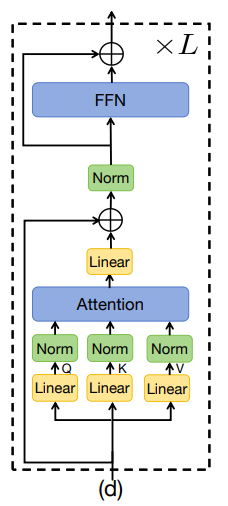

In [11]:
class TransformerBlock(nn.Module):
    """A Transformer block with RMS Norm and residual connections."""
    d_model: int  # Dimension of the model (hidden size)
    n_h: int  # Number of attention heads
    dim_feedforward: int    # Dimension of the feed-forward network
    dropout_rate: float = 0.1  # Dropout rate
    d_c : int = 64 # Latent dimension (d_c)
    d_c_: int = 64 # Latent dimension (d_c)
    d_h_R: int = 32  # Rotated dimension (d_h^R)
    position: bool = False


    def setup(self):
        # Attention layer
        if self.position:
            self.self_attn = MultiHeadLatentAttentionRope(
                d_model = self.d_model,
                n_h = self.n_h,
                d_c = self.d_c,
                d_c_ = self.d_c_,
                d_h_R = self.d_h_R)
        else:
            self.self_attn = MultiHeadLatentAttention(
                d_model = self.d_model,
                n_h = self.n_h,
                d_c = self.d_c,
                d_c_ = self.d_c_)
            

        # Feed-Forward Network
        self.ffn = [
            nn.Dense(features=self.dim_feedforward,
                     kernel_init=nn.initializers.xavier_uniform(),
                     bias_init=nn.initializers.zeros),
            nn.gelu,
            nn.Dropout(self.dropout_rate),
            nn.Dense(features=self.d_model,
                     kernel_init=nn.initializers.xavier_uniform(),
                     bias_init=nn.initializers.zeros),
            nn.Dropout(self.dropout_rate)
        ]
            
         
        # Layers to apply in between the main layers
        # self.rmsNorm1 = nn.RMSNorm()
        self.rmsNorm2 = nn.RMSNorm()
        self.dropout = nn.Dropout(self.dropout_rate)


    
    def __call__(self, x: jnp.ndarray, mask: Optional[jnp.ndarray] = None, train: bool = False) -> jnp.ndarray:
        """
        Args:
            x: Input tensor of shape (batch, length, d_model)
            mask: Attention mask of shape (batch, heads, length, length) or None
            train: Whether in training mode (for dropout)
        Returns:
            Output tensor of shape (batch, length, d_model)
        """
        # First RMS Norm + Residual Connection
        residual = x
        # x = self.rmsNorm1(x)
        x, _= self.self_attn(x, mask=mask)
        x = self.dropout(x, deterministic=not train)
        x = x + residual  # Residual connection

        # Second RMS Norm + Residual Connection
        
        x = self.rmsNorm2(x)
        x = self.dropout(x, deterministic=not train)

        residual = x
        
        for layer in self.ffn:
            x = layer(x) if not isinstance(layer, nn.Dropout) else layer(x, deterministic=not train)

        x = self.dropout(x, deterministic=not train)
        x = x + residual  # Residual connection

        return x